In [1]:
import omnipath as op
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pySankey import sankey as sn
import mellon as ml

c:\Users\melis\AppData\Local\Programs\Python\Python37\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
db = op.interactions.import_intercell_network(transmitter_params = {"categories":"ligand"}, receiver_params = {"categories": "receptor"})
db = db[np.logical_not(db['genesymbol_intercell_source'].str.startswith('HLA'))]
db = db[np.logical_not(db['genesymbol_intercell_target'].str.startswith('HLA'))]
db = db[~db['genesymbol_intercell_target'].astype(str).str.startswith('COMPLEX')]
db = db[~db['genesymbol_intercell_source'].astype(str).str.startswith('COMPLEX')]
tgts_all = pd.read_csv('/Users/melis/Documents/Gene-targets/Disease_gene_associations_OpenTargets/hot-encoded-diseases.csv')

tgts_all['gene']=tgts_all['genes']
tgts = tgts_all.drop(columns=['genes']).set_index(['gene'])
tgts

AD  ALS  AnorexiaNervosa  BipolarDisorder  BrainAneurysm  \
gene                                                                 
AATK     0.0  0.0              0.0              0.0            0.0   
ABCA1    1.0  0.0              0.0              0.0            0.0   
ABCA13   0.0  0.0              0.0              0.0            0.0   
ABCA7    1.0  0.0              0.0              0.0            0.0   
ABCB1    0.0  0.0              0.0              0.0            0.0   
...      ...  ...              ...              ...            ...   
ZSCAN23  0.0  0.0              0.0              0.0            0.0   
ZSCAN26  0.0  0.0              0.0              0.0            0.0   
ZSCAN31  0.0  0.0              0.0              1.0            0.0   
ZSCAN9   0.0  0.0              0.0              1.0            0.0   
ZSWIM6   0.0  0.0              1.0              1.0            0.0   

         EssentialTremor  FrontotemporalDementia  IntracranialHemorrhage  LBD  \
gene                                                                            
AATK                 0.0                     0.0                     0.0  0.0   
ABCA1                0.0                     0.0                     0.0  0.0   
ABCA13               0.0                     0.0                     0.0  0.0   
ABCA7                0.0                     1.0                     0.0  0.0   
ABCB1                0.0                     0.0                     0.0  0.0   
...                  ...                     ...                     ...  ...   
ZSCAN23              0.0                     0.0                     0.0  0.0   
ZSCAN26              0.0                     0.0                     0.0  0.0   
ZSCAN31              0.0                     0.0                     0.0  0.0   
ZSCAN9               0.0                     0.0                     0.0  0.0   
ZSWIM6               0.0                     0.0                     0.0  0.0   

         MajorDepressiveDisorder  ...  Narcolepsy  NeuroticDisorder  OCD  \
gene                              ...                                      
AATK                         0.0  ...         0.0               1.0  0.0   
ABCA1                        0.0  ...         0.0               0.0  0.0   
ABCA13                       0.0  ...         0.0               0.0  0.0   
ABCA7                        0.0  ...         0.0               0.0  0.0   
ABCB1                        0.0  ...         0.0               0.0  0.0   
...                          ...  ...         ...               ...  ...   
ZSCAN23                      0.0  ...         0.0               0.0  0.0   
ZSCAN26                      1.0  ...         0.0               0.0  0.0   
ZSCAN31                      1.0  ...         0.0               0.0  0.0   
ZSCAN9                       0.0  ...         0.0               0.0  0.0   
ZSWIM6                       0.0  ...         0.0               0.0  1.0   

         PartialEpilepsy   PD  ProgressiveSupranuclearPalsy  RestlessLeg  \
gene                                                                       
AATK                 0.0  0.0                           0.0          0.0   
ABCA1                0.0  0.0                           0.0          0.0   
ABCA13               0.0  0.0                           0.0          0.0   
ABCA7                0.0  0.0                           0.0          0.0   
ABCB1                0.0  0.0                           0.0          0.0   
...                  ...  ...                           ...          ...   
ZSCAN23              0.0  0.0                           0.0          0.0   
ZSCAN26              0.0  0.0                           0.0          0.0   
ZSCAN31              0.0  0.0                           0.0          0.0   
ZSCAN9               0.0  0.0                           0.0          0.0   
ZSWIM6               0.0  0.0                           0.0          0.0   

         Schizophrenia  TouretteSyndrome  UnipolarDepression  
gene

In [3]:
source, percSrc, targets, percTgt, sum = ml.lr.find_hits(tgts, db)
tgts.drop('Empty', axis = 1, inplace = True)

#Keep LRs where at least one interactor is associated with disease
LRs = db[['genesymbol_intercell_source','genesymbol_intercell_target']][(db['genesymbol_intercell_source'].isin(list(sum.gene))) | (db['genesymbol_intercell_target'].isin(list(sum.gene)))]

unique_genes = np.unique(list(LRs['genesymbol_intercell_source'])+list(LRs['genesymbol_intercell_target']))

#Make an empty pandas dataframe to populate with all interactions where at least one interactor is associated with disease
risk_connectors = pd.DataFrame(np.zeros(shape=(len(unique_genes), len(tgts.columns))), columns=list(tgts.columns), index=unique_genes)


In [4]:
#Actually populate the dataframe

for n in range(0,len(tgts.columns)):
    disease_tgts = tgts[tgts.iloc[:,n]>0.0]
    disease_source, disease_percSrc, disease_targets, disease_percTgt, disease_sum = ml.lr.find_hits(disease_tgts, db)
    disease_LRs = db[['genesymbol_intercell_source','genesymbol_intercell_target']][(db['genesymbol_intercell_source'].isin(list(disease_sum.gene))) | (db['genesymbol_intercell_target'].isin(list(disease_sum.gene)))]
    disease_LRs_unique = pd.concat([disease_LRs['genesymbol_intercell_source'], disease_LRs['genesymbol_intercell_target']]).unique()
    for m in range(0,len(disease_LRs_unique)):
        print(disease_LRs_unique[m])
        print(risk_connectors.loc[disease_LRs_unique[m]])
        risk_connectors.iloc[risk_connectors.index.get_loc(disease_LRs_unique[m]), n] = 1.0
    

c:\Users\melis\Documents\GitHub\LR_project\mellon\lr\find_hits.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target['Empty'] = 0


IL6R
AD                              0.0
ALS                             0.0
AnorexiaNervosa                 0.0
BipolarDisorder                 0.0
BrainAneurysm                   0.0
EssentialTremor                 0.0
FrontotemporalDementia          0.0
IntracranialHemorrhage          0.0
LBD                             0.0
MajorDepressiveDisorder         0.0
MigraineDisorder                0.0
MigraineWithAura                0.0
MS                              0.0
NarcolepsyCataplexy             0.0
Narcolepsy                      0.0
NeuroticDisorder                0.0
OCD                             0.0
PartialEpilepsy                 0.0
PD                              0.0
ProgressiveSupranuclearPalsy    0.0
RestlessLeg                     0.0
Schizophrenia                   0.0
TouretteSyndrome                0.0
UnipolarDepression              0.0
Name: IL6R, dtype: float64
HGF
AD                              0.0
ALS                             0.0
AnorexiaNervosa             

In [ ]:







sns.clustermap(risk_connectors)
plt.savefig('plots/02-clustering_with_LR_partners/clustermap_binary_partners.png', dpi = 150)
plt.show()

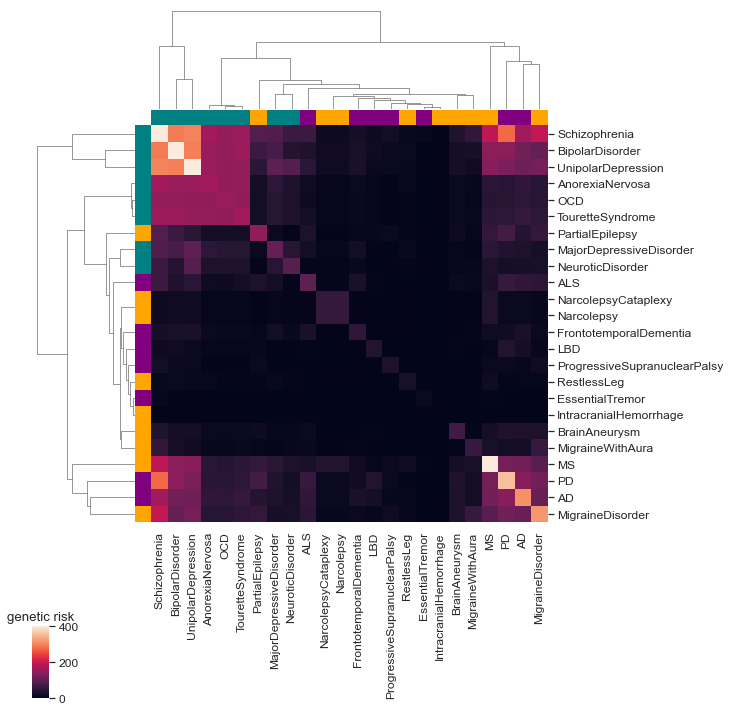

In [21]:
lut = {'AD' : 'purple',
 'ALS' : 'purple',
 'AnorexiaNervosa' : 'teal',
 'BipolarDisorder' : 'teal',
 'BrainAneurysm' : 'orange',
 'EssentialTremor' : 'purple',
 'FrontotemporalDementia' : 'purple',
 'IntracranialHemorrhage' : 'orange',
 'LBD' : 'purple',
 'MajorDepressiveDisorder' : 'teal',
 'MigraineDisorder' : 'orange',
 'MigraineWithAura' : 'orange',
 'MS' : 'orange',
 'NarcolepsyCataplexy' : 'orange',
 'Narcolepsy' : 'orange',
 'NeuroticDisorder' : 'teal',
 'OCD' : 'teal',
 'PartialEpilepsy' : 'orange',
 'PD' : 'purple',
 'ProgressiveSupranuclearPalsy' : 'purple',
 'RestlessLeg' : 'orange',
 'Schizophrenia' : 'teal',
 'TouretteSyndrome' : 'teal',
 'UnipolarDepression' : 'teal'}
row_colors = risk_connectors.columns.unique().map(lut)
sns.set(font_scale = 1.1)
g = sns.clustermap(risk_connectors.T.dot(risk_connectors), vmax = 400, row_colors=row_colors, col_colors = row_colors)
x0, _y0, _w, _h = g.cbar_pos
g.ax_cbar.set_position([x0, 0.02, g.ax_row_dendrogram.get_position().width/6, 0.1])
g.ax_cbar.set_title('genetic risk')
plt.savefig('plots/02-clustering_with_LR_partners/clustermap_overlaps_LR_network.png', dpi = 300)
plt.show()

In [7]:
df = pd.read_csv('/Users/melis/Documents/Gene-targets/Disease_gene_associations_OpenTargets/hot-encoded-diseases.csv')
df = df.drop_duplicates(subset = ['genes'])
df = df.set_index('genes')

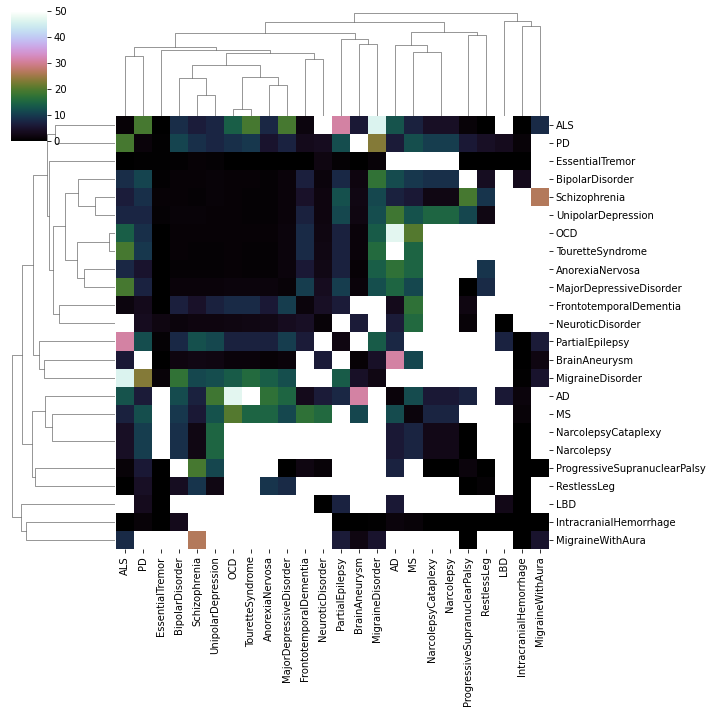

In [8]:
sns.clustermap((risk_connectors.T.dot(risk_connectors)/df.T.dot(df)).replace(to_replace = np.inf, value = 50).replace(np.nan, value = 0), cmap = 'cubehelix', vmax = 50)
plt.savefig('plots/02-clustering_with_LR_partners/clustermap_ratio_LRrisknetwork_diseaseriskassociation.png', dpi = 150)
plt.show()